# Отток клиентов банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul>

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

## Подготовка данных

In [1]:
# загрузим библиотеки
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты собраны где нужно =)
</div>

In [2]:
# прочитаем файл с данными
df = pd.read_csv('/datasets/Churn.csv')
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9091.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     4.997690   
std     2886.89568  7.1936

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# проверим пропуски
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,9.09
Balance,0
NumOfProducts,0


Датафрейм состоит из 10000 строк.14 признаков, из них 3 являются float64, 8 - int64 и 3- object. Есть пропуски в стоолбце Tenure - необходимо заполнить. Можно предположить, что клиенты просто новые и годы еще нельзя подсчитать, возможен вариант, что эти клиенты уже ушли. У 25% нулевые остатки на счетах, отсутствуют кредитные карты и 0 активность.

In [4]:
# заменим названия столбцов, приведем к нижнему регистру
df.columns = df.columns.str.lower()
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
# удалим ненужные столбцы, которые не влияют на результаты нашего исследования
df = df.drop(['rownumber', 'surname', 'customerid'], axis=1)

In [6]:
# Заменим пропуски в столбце Tenure на медианное значение. 
# В процентном соотношении пропусков не так много, около 10%. Медиана будет оптимальным значением.
df_first = df.fillna(df['tenure'].median())
print(df_first['tenure'].isna().sum())
print(df_first.shape)

0
(10000, 11)


In [7]:
# преобразуем категориальные признаки в численные
df_ohe = pd.get_dummies(df_first, drop_first = True)
df_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [8]:
# посмотрим, что получилось в итоге
print(df_ohe.info())
df_ohe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
creditscore          10000 non-null int64
age                  10000 non-null int64
tenure               10000 non-null float64
balance              10000 non-null float64
numofproducts        10000 non-null int64
hascrcard            10000 non-null int64
isactivemember       10000 non-null int64
estimatedsalary      10000 non-null float64
exited               10000 non-null int64
geography_Germany    10000 non-null uint8
geography_Spain      10000 non-null uint8
gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB
None


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [9]:
# Разделим обучающий датафрейм на features и target - целевой признак
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)

In [10]:
# Поделим датафрейм на обучающую и валидационную выборку

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)



In [11]:
# выведем размерности полученных переменных
var_list = [target_train, target_valid, features_train, features_valid]
for var in var_list:
    print(var.shape)

(7500,)
(2500,)
(7500, 11)
(2500, 11)


In [12]:
features_train.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'geography_Germany',
       'geography_Spain', 'gender_Male'],
      dtype='object')

In [13]:
# проведем масштабирование признаков
numeric = ['creditscore', 'age', 'tenure','balance', 'numofproducts', 'estimatedsalary']
# проведем масштабирование features_train
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

print(features_train.head())
features_valid.head()

      creditscore       age    tenure   balance  numofproducts  hascrcard  \
226      0.442805 -0.841274  1.446098 -1.224577       0.817772          1   
7756    -0.310897 -0.270730  0.719099  0.641783      -0.896874          1   
2065    -0.259274 -0.556002  1.082599 -1.224577       0.817772          1   
2800     1.217157  1.155631  1.446098  1.290462       0.817772          1   
7028     0.690598 -1.221637 -0.007900  1.142121      -0.896874          0   

      isactivemember  estimatedsalary  geography_Germany  geography_Spain  \
226                1        -1.269750                  0                0   
7756               1         0.960396                  0                1   
2065               0         0.661864                  0                0   
2800               0        -1.039476                  0                0   
7028               0        -0.851729                  1                0   

      gender_Male  
226             0  
7756            0  
2065          

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7867,-0.114728,0.680178,-0.734899,-1.224577,-0.896874,1,1,0.969342,0,1,0
1402,1.093261,-0.936365,1.082599,0.865861,-0.896874,1,0,-0.395081,0,0,1
8606,1.609496,0.299815,-0.007900,-1.224577,0.817772,1,1,-0.439560,0,1,1
8885,0.174363,0.585087,-0.371400,0.419555,0.817772,1,1,1.006040,0,1,1
6494,0.494429,-1.031456,0.719099,-1.224577,0.817772,1,1,-1.343789,0,0,1


Мы провели предобработку данных, удалили ненужные столбцы, переименовали столбцы, заполнили пропуски, преобразовали категориальные признаки в численные. Также, мы разделили данные на обучающую и валидационную выборки и масштабировали данные, чтобы исключить приоритетность того или иного признака. Перейдем к исследованию данных.

## Исследование задачи

0    0.7963
1    0.2037
Name: exited, dtype: float64


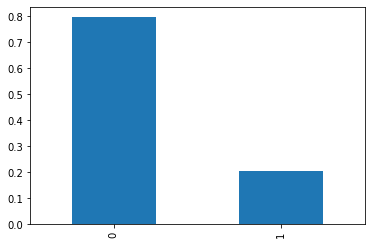

In [14]:
# исследуем баланс классов
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Идеальный баланс 50 на 50. У нас 80 на 20, будем работать с этим.

In [15]:
# проверим на дереве решений
model = DecisionTreeClassifier(random_state=12345, max_depth = 3)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

# Сравним модель со случайной
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy: 0.8348
F1: 0.45152722443559096
AUC-ROC: 0.8031970702242516


In [16]:
# случайный лес
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

# Сравним модель со случайной
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))


Accuracy: 0.848
F1: 0.5421686746987953
AUC-ROC: 0.8132634182302443


In [17]:
# логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1:', f1_score(target_valid, predicted_valid))

# Сравним модель со случайной
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

Accuracy: 0.7972
F1: 0.2948539638386648
AUC-ROC: 0.7585579415471689


In [18]:
df_all = pd.DataFrame([['DesicionTree', 0.83, 0.45, 0.8],
                  ['RandomForest', 0.85, 0.54, 0.81],
                  ['LogisticRegression', 0.8, 0.29, 0.76]], 
columns=['name', 'Accuracy', 'F1', 'AUC-ROC'])
df_all

,name,Accuracy,F1,AUC-ROC
0,DesicionTree,0.83,0.45,0.80
1,RandomForest,0.85,0.54,0.81
2,LogisticRegression,0.80,0.29,0.76


F1 больше или равна 0,59 - это наша цель. Пока только случайный лес показывает значение 0,54, остальные ниже. Точность высока у всех моделей. Необходимо откорректировать дисбаланс классов.

## Борьба с дисбалансом

Придадим объектам редкого класса больший вес.
В алгоритмах решающего дерева, случайного леса и логистической регрессии в библиотеке sklearn есть аргумент class_weight.
Используем его, обучая модели.

In [19]:
logistic_model = LogisticRegression(random_state=12345, class_weight='balanced')
logistic_model.fit(features_train, target_train)
logistic_predicted_valid = logistic_model.predict(features_valid)

tree_model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
tree_model.fit(features_train, target_train)
tree_predicted_valid = tree_model.predict(features_valid)

forest_model = RandomForestClassifier(random_state=12345, class_weight='balanced')
forest_model.fit(features_train, target_train)
forest_predicted_valid = forest_model.predict(features_valid)

print('F1_LogisticRegression :{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1_DecisionTreeClassifier:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1_RandomForestClassifier:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))

F1_LogisticRegression :0.51
F1_DecisionTreeClassifier:0.51
F1_RandomForestClassifier:0.53


Увеличим выборку методом upsampling

In [20]:
# Разделим обучающую выборку на отрицательные и положительные объекты
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(5998, 11)
(1502, 11)
(5998,)
(1502,)


In [21]:
# Скопируем несколько раз положительные объекты. С учётом полученных данных создадим новую обучающую выборку.
# Перемешаем данные.
# Напишем функцию upsample(features, target, repeat) для формирования сблалансированной выборки

def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = repeat
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)


(12006, 11)
(12006,)


In [22]:
# обучим модели на новой, расширенной выборке
logistic_model = LogisticRegression(random_state=12345)
logistic_model.fit(features_upsampled, target_upsampled)
logistic_predicted_valid = logistic_model.predict(features_valid)

tree_model = DecisionTreeClassifier(random_state=12345)
tree_model.fit(features_upsampled, target_upsampled)
tree_predicted_valid = tree_model.predict(features_valid)

forest_model = RandomForestClassifier(random_state=12345)
forest_model.fit(features_upsampled, target_upsampled)
forest_predicted_valid = forest_model.predict(features_valid)

print('F1_LogisticRegression:{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1_DecisionTreeClassifier:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1_RandomForestClassifier:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))

F1_LogisticRegression:0.50
F1_DecisionTreeClassifier:0.49
F1_RandomForestClassifier:0.59


F1_RandomForestClassifier:0.59. Целевое значение метрики достигнуто. Попробуем уменьшить выборку.

In [23]:
# Уменьшим выборку методом downsampling
# Напишем функцию downsample(features, target, repeat) для формирования сблалансированной выборки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(3002, 11)
(3002,)


In [24]:
# обучим модели на уменьшенной выборке

logistic_model = LogisticRegression(random_state=12345)
logistic_model.fit(features_downsampled, target_downsampled)
logistic_predicted_valid = logistic_model.predict(features_valid)

tree_model = DecisionTreeClassifier(random_state=12345)
tree_model.fit(features_downsampled, target_downsampled)
tree_predicted_valid = tree_model.predict(features_valid)

forest_model = RandomForestClassifier(random_state=12345)
forest_model.fit(features_downsampled, target_downsampled)
forest_predicted_valid = forest_model.predict(features_valid)

print('F1_LogisticRegression:{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1_DecisionTreeClassifier:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1_RandomForestClassifier:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))

F1_LogisticRegression:0.51
F1_DecisionTreeClassifier:0.49
F1_RandomForestClassifier:0.59


Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC

In [25]:
# Напишем функцию auc_roc(model), которая строит roc-кривую и вычисляет AUC-ROC

def auc_roc(model, name):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC-кривая'.format(name))
    plt.show()
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('AUC-ROC равно:', auc_roc)
    return 

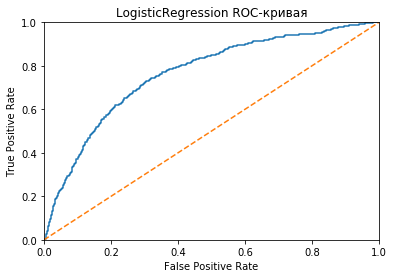

AUC-ROC равно: 0.76451356685929


In [26]:
auc_roc(logistic_model, 'LogisticRegression')

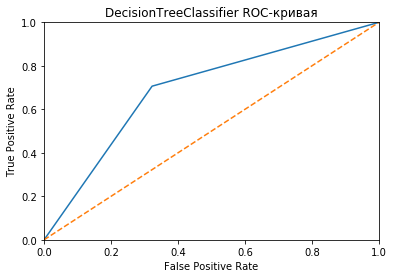

AUC-ROC равно: 0.6919478728210982


In [27]:
auc_roc(tree_model, 'DecisionTreeClassifier')

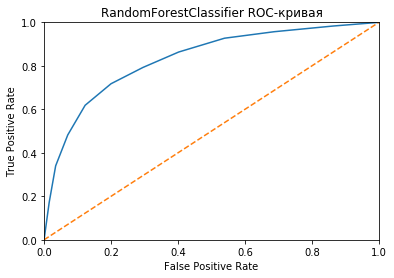

AUC-ROC равно: 0.830353618225488


In [28]:
auc_roc(forest_model, 'RandomForestClassifier')

Подберем гиперпараметры

In [29]:
# DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=12345)
tree_model.fit(features_upsampled, target_upsampled)
tree_predicted_valid = tree_model.predict(features_valid)
f1_score(target_valid, tree_predicted_valid)

0.4900662251655629

In [30]:
# max_depth - максимальная глубина дерева. Переберем в цикле значения от 1 до 20

for depth in range(1,21):
    tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree_model.fit(features_upsampled, target_upsampled)
    tree_predicted_valid = tree_model.predict(features_valid)
    print('Глубина дерева:', depth, 'F1-мера:', f1_score(target_valid, tree_predicted_valid))

Глубина дерева: 1 F1-мера: 0.5070202808112324
Глубина дерева: 2 F1-мера: 0.5391566265060241
Глубина дерева: 3 F1-мера: 0.5391566265060241
Глубина дерева: 4 F1-мера: 0.5440414507772021
Глубина дерева: 5 F1-мера: 0.6016129032258064
Глубина дерева: 6 F1-мера: 0.5878962536023055
Глубина дерева: 7 F1-мера: 0.5859154929577465
Глубина дерева: 8 F1-мера: 0.5821114369501467
Глубина дерева: 9 F1-мера: 0.5739005046863735
Глубина дерева: 10 F1-мера: 0.5569811320754717
Глубина дерева: 11 F1-мера: 0.5537974683544303
Глубина дерева: 12 F1-мера: 0.5396825396825397
Глубина дерева: 13 F1-мера: 0.5192465192465192
Глубина дерева: 14 F1-мера: 0.5012701100762066
Глубина дерева: 15 F1-мера: 0.510600706713781
Глубина дерева: 16 F1-мера: 0.5
Глубина дерева: 17 F1-мера: 0.5009107468123862
Глубина дерева: 18 F1-мера: 0.49355432780847147
Глубина дерева: 19 F1-мера: 0.4967197750702905
Глубина дерева: 20 F1-мера: 0.500945179584121


оптимальное значение max_depth=5

In [31]:
# RandomForestClassifier

forest_model = RandomForestClassifier(random_state=12345)
forest_model.fit(features_upsampled, target_upsampled)
forest_predicted_valid = forest_model.predict(features_valid)
f1_score(target_valid, forest_predicted_valid)

0.5928270042194094

In [32]:
# n_estimators - количество деревьев. Переберем в цикле значения от 5 до 150 с шагом 5

for estimators in range(5,151,5):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=estimators)
    forest_model.fit(features_upsampled, target_upsampled)
    forest_predicted_valid = forest_model.predict(features_valid)
    print(estimators,':', f1_score(target_valid, forest_predicted_valid))

5 : 0.5768863419293219
10 : 0.5928270042194094
15 : 0.6087824351297405
20 : 0.6068111455108359
25 : 0.6124497991967871
30 : 0.6120777891504606
35 : 0.6012145748987854
40 : 0.6014418125643666
45 : 0.6133603238866396
50 : 0.6201232032854209
55 : 0.617737003058104
60 : 0.6134969325153373
65 : 0.6109979633401221
70 : 0.6115702479338843
75 : 0.6120777891504606
80 : 0.6182572614107884
85 : 0.6163391933815925
90 : 0.6128364389233953
95 : 0.6180698151950719
100 : 0.6199794026776518
105 : 0.6153846153846154
110 : 0.615859938208033
115 : 0.6145940390544707
120 : 0.6203319502074689
125 : 0.6179196704428425
130 : 0.6141078838174274
135 : 0.6138002059732235
140 : 0.6141078838174274
145 : 0.6206185567010308
150 : 0.6169772256728778


оптимальное значение n_estimators=145

In [33]:
# max_depth - максимальная глубина дерева. Переберем в цикле значения от 1 до 30

for depth in range(1,31):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=145, max_depth=depth)
    forest_model.fit(features_upsampled, target_upsampled)
    forest_predicted_valid = forest_model.predict(features_valid)
    print('Глубина дерева:', depth, 'F1-мера:', f1_score(target_valid, forest_predicted_valid))

Глубина дерева: 1 F1-мера: 0.5420827389443652
Глубина дерева: 2 F1-мера: 0.5628654970760234
Глубина дерева: 3 F1-мера: 0.5915080527086384
Глубина дерева: 4 F1-мера: 0.6105733432613552
Глубина дерева: 5 F1-мера: 0.6204772902232488
Глубина дерева: 6 F1-мера: 0.630220197418375
Глубина дерева: 7 F1-мера: 0.6415686274509804
Глубина дерева: 8 F1-мера: 0.644904458598726
Глубина дерева: 9 F1-мера: 0.6433224755700326
Глубина дерева: 10 F1-мера: 0.6336134453781513
Глубина дерева: 11 F1-мера: 0.6319444444444444
Глубина дерева: 12 F1-мера: 0.6344086021505376
Глубина дерева: 13 F1-мера: 0.6333647502356268
Глубина дерева: 14 F1-мера: 0.6285160038797285
Глубина дерева: 15 F1-мера: 0.6141732283464567
Глубина дерева: 16 F1-мера: 0.618
Глубина дерева: 17 F1-мера: 0.6234817813765182
Глубина дерева: 18 F1-мера: 0.6292134831460674
Глубина дерева: 19 F1-мера: 0.6194871794871795
Глубина дерева: 20 F1-мера: 0.6136363636363636
Глубина дерева: 21 F1-мера: 0.6134969325153373
Глубина дерева: 22 F1-мера: 0.6136363

Оптимальное значение max_depth=8

Качество модели наилучшее при n_estimators=145, max_depth=8

In [34]:
# LogisticRegression

logistic_model = LogisticRegression(random_state=12345, solver='liblinear', warm_start=True, multi_class='ovr')
logistic_model.fit(features_upsampled, target_upsampled)
logistic_predicted_valid = logistic_model.predict(features_valid)
f1_score(target_valid, logistic_predicted_valid)

0.5043478260869565

Изменение гиперпараметров не улучшает качество LogisticRegression.

Т.к. изначально и уменьшение и увеличение выборки показало одинаковые результаты, давайте проверим на подобранных иттоговых значениях, что лучше.

In [35]:
# уменьшение

forest_model = RandomForestClassifier(random_state=12345, n_estimators=145, max_depth=8)
forest_model.fit(features_downsampled, target_downsampled)
forest_predicted_valid = forest_model.predict(features_valid)
print('Глубина дерева:', depth, 'F1-мера:', f1_score(target_valid, forest_predicted_valid))

Глубина дерева: 30 F1-мера: 0.6178623718887263


In [36]:
# увеличение

forest_model = RandomForestClassifier(random_state=12345, n_estimators=145, max_depth=8)
forest_model.fit(features_upsampled, target_upsampled)
forest_predicted_valid = forest_model.predict(features_valid)
print('Глубина дерева:', depth, 'F1-мера:', f1_score(target_valid, forest_predicted_valid))

Глубина дерева: 30 F1-мера: 0.644904458598726


Мы сбалансировали классы, увеличили и уменьшили выборку, построили ROC кривые для каждой модели и посчитали AUC-ROC. В итоге оптимальная модель RandomForestClassifier при n_estimators=145, max_depth=8. Увеличение выборки оказалось оптимальным методом балансировки. Результаты проверены с применением итоговых оптимальных гиперпараметров.

Применим GridSearchCV, параметр кросс-валидации cv=4.

In [47]:
%%time
# импортируем алгоритм исчерпывающего поиска по гиперпараметрам
from sklearn.model_selection import GridSearchCV

# сетка гиперпараметров, по которой будет происходит исчерпывающий поиск
param_grid = {
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 151, 10).astype(int)),
    'min_samples_split': [2, 5, 10]
}

# дерево принятия решений к которому будем подбирать параметры
estimator = DecisionTreeClassifier(random_state = 12345)

# модель
model = GridSearchCV(estimator, param_grid, cv=4, scoring = 'f1')

# обучаем модель
model.fit(features_upsampled, target_upsampled)

CPU times: user 1min 34s, sys: 129 ms, total: 1min 35s
Wall time: 1min 35s


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=12345,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18,
                                       20],
              

In [48]:
# среднее значение F1-меры по разным выборкам
model.best_score_

0.9251482226163725

In [49]:
# набор параметров, которые подобрал исчерпывающий поиск по гиперпараметрам модели
model.best_params_

{'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_split': 2}

Попробуем RandomizedSearchCV - случайный поиск по гиперпараметрам с моделью случайного леса.

In [51]:
%%time
# Импортируем алгоритм случайного поиска по гиперпараметрам
from sklearn.model_selection import RandomizedSearchCV


# сетка гиперпараметров, по которой будет происходит случайный поиск
param_grid = {
    'n_estimators': list(np.arange(2, 151, 2).astype(int)),
    'max_depth': [None] + list(np.arange(2, 21,2).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'max_leaf_nodes': [None] + list(np.arange(10, 101, 10).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# случайный лес к которому будем подбирать параметры
estimator = RandomForestClassifier(random_state = 12345)

# модель
model_rf = RandomizedSearchCV(estimator, param_grid, cv=4, scoring = 'f1')

# обучаем модель
model_rf.fit(features_upsampled, target_upsampled)

CPU times: user 18.9 s, sys: 12.2 ms, total: 18.9 s
Wall time: 18.9 s


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [52]:
# <среднее значение F1-меры по разным выборкам>
model_rf.best_score_

0.8034339983453559

Алгоритм случайного поиска по гиперпарметрам дал отличный результат F1-0.8, однако алгоритм исчерпывающего поиска по гиперпараметрам GridSearchCV показал результат лучше F1-0.93.

## Тестирование модели

Объеденим обучающую и валидационную выборку, используя метод append и concat, для того чтобы добавить еще качества

In [38]:
# Объеденим обучающую(увеличенную) и валидационную выборку, используя метод append  и concat, для того чтобы добавить еще качества
features_train_valid = features_upsampled.append(features_valid, ignore_index=True)
# target_train_valid = target_upsampled.append(target_valid<ignore_index=True)
target_train_valid = pd.concat([target_upsampled, target_valid])

print(features_train_valid.shape)
print(target_train_valid.shape)
features_train_valid.head()

(14506, 11)
(14506,)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
0,0.071116,-0.365820,-0.007900,0.803154,-0.896874,0,0,0.971100,0,0,0
1,0.731897,-0.175639,-1.825398,0.796418,-0.896874,0,0,1.036919,1,0,0
2,-0.868431,0.680178,-1.461898,-0.129863,0.817772,1,1,0.160852,1,0,0
3,-0.692911,-0.080548,1.446098,0.453211,-0.896874,1,0,1.322933,0,0,1
4,0.525403,0.680178,1.446098,0.354711,-0.896874,0,1,0.160691,0,0,0


In [65]:
# Вычислим значение f1 меры модели при оптимальных гиперпараметрах, подобранных вручную

forest_model = RandomForestClassifier(random_state=12345, n_estimators=145, max_depth=8)
forest_model.fit(features_train_valid, target_train_valid)

forest_predicted_valid = forest_model.predict(features_valid)
print('F1-мера:', f1_score(target_valid, forest_predicted_valid))

F1-мера: 0.6866197183098591


In [64]:
# Вычислим значение f1 меры модели при оптимальных гиперпараметрах, подобранных GridSearchCV
model_GridSearchCV = RandomForestClassifier(max_depth=None,
 max_features=None,
 max_leaf_nodes=None,
 min_samples_split=2)
model_GridSearchCV.fit(features_train_valid, target_train_valid)

forest_predicted_valid = model_GridSearchCV.predict(features_valid)
print('F1-мера:', f1_score(target_valid, forest_predicted_valid))

F1-мера: 0.9507246376811594


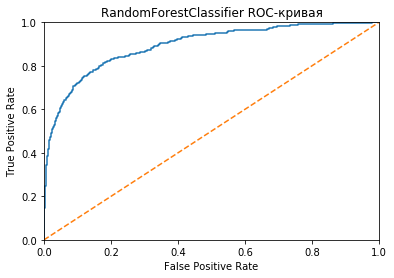

AUC-ROC равно: 0.894034386816009


In [66]:
# Построим roc-кривую и вычислим AUC-ROC для нашей модели

auc_roc(forest_model, 'RandomForestClassifier')

Модель RandomForestClassifier с оптимальными гиперпараметрами n_estimators=145, max_depth=8,  показала F1-меру: 0.69, AUC-ROC равное: 0.89. Цель достигнута.

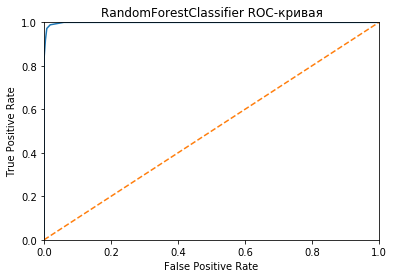

AUC-ROC равно: 0.9988195286675704


In [68]:
# Построим roc-кривую и вычислим AUC-ROC для  model_GridSearchCV

auc_roc(model_GridSearchCV, 'RandomForestClassifier')

Давайте проанализируем влияние факторов на целевую. Применим feature_importances.

In [69]:
# Создадим датафрейм факторов и их значимости

importances = forest_model.feature_importances_
feature_list = list(features_train_valid.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results.head(11)

,feature,importance
0,creditscore,0.037049
1,age,0.373559
2,tenure,0.018730
3,balance,0.089619
4,numofproducts,0.279553
5,hascrcard,0.004500
6,isactivemember,0.071914
7,estimatedsalary,0.036183
8,geography_Germany,0.061048
9,geography_Spain,0.005457


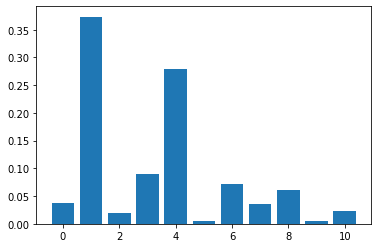

In [70]:
# построим график, оценим визуально
import matplotlib.pyplot as plt

plt.bar(range(len(forest_model.feature_importances_)), forest_model.feature_importances_)
plt.show()

In [71]:
# выведем факторы по важности

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results.head(11)

,feature,importance
0,age,0.373559
1,numofproducts,0.279553
2,balance,0.089619
3,isactivemember,0.071914
4,geography_Germany,0.061048
5,creditscore,0.037049
6,estimatedsalary,0.036183
7,gender_Male,0.022389
8,tenure,0.018730
9,geography_Spain,0.005457


Основные факторы: возраст, баланс счета, предполагаемая зарплата, кредитный рейтинг и количество продуктов банка. Это интересно!

### Общий вывод

* Цель проекта. 

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Построить модель с предельно большим значением F1-меры. Нужно довести метрику до 0.59. 
* Результат. 

Цель достигнута. Создана, обучена и настроена модель с F1=0,64.